In [1]:
%matplotlib inline
import matplotlib
# matplotlib.use('TkAgg')
import keras
import numpy as np
import pandas as pd

workdir = "/home/jlg374/projects/protein_diverse_maize/"
ww_workdir = "/media/jlg374/Data1/protein_diverse_maize/wang_washburn_model/"
genome_dir = "/media/jlg374/Data1/protein_diverse_maize/references/"

# Where to save pickle with one-hot encoded sequences
oh_seq_pickle = ww_workdir+"gene_oh.pkl"
# Path to pretrained model weights from WW paper
ww_model = "pro_term1.5_sb_zm_SC_CO2k_fold0rep0fold0.h5"
# Path to proteomic comparisons
protein_path = workdir+"data/fourGenos_peptidePairs_abundance_RNA_allTissues.txt"

# Pull seqs from fasta and one-hot encode them?
# Not necessary if already done once and saved.
oh_encode_seqs = False

inbreds = ["B73", "Mo17", "P39", "CML103"]


Using TensorFlow backend.


The next cell is entirely functions from Washburn and Wang 2019 (https://bitbucket.org/bucklerlab/p_strength_prediction/src/master/notebook/Extract_sequences_from_ref.py)

In [2]:
##################
# Huge block of functions from Washburn/Wang to help
#  pull pro/term sequences and one-hot encode them.
##################
import sys, os
import pprint
from BCBio import GFF
from BCBio.GFF import GFFExaminer
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
import h5py
from sklearn.preprocessing import OneHotEncoder
import numpy
import pickle

# 'if True' just lets me collapse this whole block in PyCharm
#  so I don't have to look at it.
if True:
    def get_gene_pos(in_file):
        limit_info = dict(#gff_id = ["1"],
                          gff_type = ["gene"])
        #print limit_info
        gene_pos_df=[]
        in_handle = open(in_file)
        for rec in GFF.parse(in_handle, limit_info=limit_info):
            for feature in rec.features:
                gene=feature
                gene_pos_df.append(tuple([rec.id, gene.qualifiers['gene_id'][0], int(gene.location.start), int(gene.location.end), gene.location.strand]))
                #gene_len_dict[gene.qualifiers['gene_id'][0]] = int(gene.location.end) - int(gene.location.start)
            #print rec.features
        in_handle.close()
        gene_pos_df=pd.DataFrame(gene_pos_df, columns=['Chr','Gene_ID','Start','End','Strand'])
        return gene_pos_df#, gene_len_dict

    def get_gene_pos_phytozome(in_file):
        limit_info = dict(#gff_id = ["1"],
                          gff_type = ["gene"])
        #print limit_info
        gene_pos_df=[]
        in_handle = open(in_file)
        for rec in GFF.parse(in_handle, limit_info=limit_info):
            for feature in rec.features:
                gene=feature
                gene_pos_df.append(tuple([rec.id, gene.qualifiers['ID'][0], int(gene.location.start), int(gene.location.end), gene.location.strand]))
                #gene_len_dict[gene.qualifiers['gene_id'][0]] = int(gene.location.end) - int(gene.location.start)
            #print rec.features
        in_handle.close()
        gene_pos_df=pd.DataFrame(gene_pos_df, columns=['Chr','Gene_ID','Start','End','Strand'])
        return gene_pos_df#, gene_len_dict

    def get_strt_codon_pos_phytozome(in_file):
        limit_info = dict(#gff_id = ["Chr01"],
                          gff_type = ["CDS"])
        #print limit_info
        gene_pos_dict={}
        in_handle = open(in_file)
        for rec in GFF.parse(in_handle, limit_info=limit_info, target_lines=1):
            for feature in rec.features:
                gene=feature
                #determin how to parse gene names based on which genome they came from
                if gene.qualifiers['Parent'][0][:6]=="Sobic.":
                    gene_name=gene.qualifiers['Parent'][0][:16]
                if gene.qualifiers['Parent'][0][:6]=="ZmMO17":
                    gene_name=gene.qualifiers['Parent'][0].replace("t","g").split("_")[0]
                if gene.qualifiers['Parent'][0][:11]=="transcript:":
                    gene_name=gene.qualifiers['Parent'][0].split("transcript:")[1].split("_")[0]
                #add genes to dictionary and determine which is the first CDS
                if gene_name not in gene_pos_dict:
                    gene_pos_dict[gene_name]=tuple([rec.id,gene_name,int(gene.location.start),
                                                    int(gene.location.end), gene.location.strand])
                else:
                    if gene.location.strand==1:
                        if int(gene.location.start) < gene_pos_dict[gene_name][2]:
                            gene_pos_dict[gene_name]=tuple([rec.id, gene_name, int(gene.location.start),
                                                            int(gene.location.end), gene.location.strand])
                    if gene.location.strand==-1:
                        if int(gene.location.end) > gene_pos_dict[gene_name][3]:
                            gene_pos_dict[gene_name]=tuple([rec.id, gene_name, int(gene.location.start),
                                                            int(gene.location.end), gene.location.strand])
        in_handle.close()
        gene_pos_df=pd.DataFrame(gene_pos_dict, index=['Chr','Gene_ID','Start','End','Strand']).T.sort_values(by="Chr")
        return gene_pos_df #, gene_len_dict

    def extract_region_by_strt_codon(genome, df, gene_dict):
        added_Ns=[]
        strt_codon_error=[]
        chromesome=['','']
        size=2000
        for row in range(0,len(df)):
            #print row
            #put current chromosome in memory
            if chromesome[0]!=df.iloc[row,0]:
                chromesome[0]=df.iloc[row,0]
                chromesome[1]=genome[df.iloc[row,0]]
            #extract region of interest for a specific gene
            Gene = df.iloc[row,:].values.tolist()
            if Gene[4]==1:
                #print("Pos strand", Gene)
                if chromesome[1].seq[Gene[2]:Gene[2]+3] == "ATG":
                    if Gene[2] < size:
                        strt=0
                        end=Gene[2]
                    else:
                        strt=Gene[2]-size
                        end=Gene[2]
                    gene_dict[Gene[1]]=chromesome[1].seq[strt:end]
                else:
                    #print("WARNING: CODON START SITE NOT ATG; "+Gene[1]+" : "+chromesome[1].seq[Gene[2]:Gene[2]+3]+" GENE EXCLUDED."
                    strt_codon_error.append(Gene[1])
            if Gene[4]==-1:
                #print("Neg strand", Gene)
                if chromesome[1].seq[Gene[3]-3:Gene[3]].reverse_complement() == "ATG":
                    strt=Gene[3]
                    end=Gene[3]+size
                    gene_dict[Gene[1]]=chromesome[1].seq[strt:end].reverse_complement()
                else:
                    #print("WARNING: CODON START SITE NOT ATG; "+Gene[1]+" : "+chromesome[1].seq[Gene[3]-3:Gene[3]].reverse_complement()+" GENE EXCLUDED")
                    strt_codon_error.append(Gene[1])
            if Gene[1] in gene_dict:
                if len(gene_dict[Gene[1]])<size:
                    added_Ns.append(Gene[1])
                    gene_dict[Gene[1]]="N"*(size-len(gene_dict[Gene[1]]))+gene_dict[Gene[1]]
        print("Good:",len(gene_dict.keys()), "N's added:", len(added_Ns), "Bad Start Codon:",len(strt_codon_error))
        return gene_dict, added_Ns,strt_codon_error

    def seq_to_oh(string_of_char):
        #setup IUPAC dictionary
        seq_dict={'A':0,'C':1,'G':2,'T':3,'N':4}
        numerical_list=[]
        for nuc in string_of_char:
            numerical_list.append(seq_dict[nuc])
        #convert to one-hot
        numerical_list=numpy.array(numerical_list)
        # onehot_encoder = OneHotEncoder(n_values=5,sparse=False)
        # Newer version of sklearn does not include the n_values argument.
        # Will need to add a category later for the (nonexistent) N's:
        onehot_encoder = OneHotEncoder(sparse=False)
        integer_label = numerical_list.reshape(len(numerical_list), 1)
        onehot_out=onehot_encoder.fit_transform(integer_label).astype('int8')
        #onehot_out=numpy.expand_dims(onehot_encoder.fit_transform(integer_label).astype('int8'), axis=0)
        return onehot_out

    def extract_region_by_pos(genome, df, gene_dict,lengths):
        skipped=[]
        chromesome=['','']
        out=lengths[0]
        inG=lengths[1]
        for row in range(0,len(df)):
            #put current chromosome in memory
            if chromesome[0]!=df.iloc[row,0]:
                chromesome[0]=df.iloc[row,0]
                chromesome[1]=genome[df.iloc[row,0]]
            #extract gene of interest
            Gene = df.iloc[row,:].values.tolist()
            if Gene[4]==1:
                #print("Pos strand", Gene)
                if Gene[2] < out:
                    skipped.append(Gene[1])
                    continue # skip genes that are too near the start of the chromosome, most of these are on scaffolds.
                else:
                    strt=Gene[2]-out
                    end=Gene[2]+inG
                    if end > len(chromesome[1]):
                        skipped.append(Gene[1])
                        continue # skip genes that are too near the end of the chromosome, most of these are on scaffolds.
                    gene_dict[Gene[1]]=chromesome[1].seq[strt:end]
            else:
                #print("Neg strand", Gene)
                if Gene[3] < inG:
                    skipped.append(Gene[1])
                    continue
                else:
                    strt=Gene[3]-inG
                    end=Gene[3]+out
                    if end > len(chromesome[1]):
                        skipped.append(Gene[1])
                        continue # skip genes that are too near the end of the chromosome, most of these are on scaffolds.
                    gene_dict[Gene[1]]=chromesome[1].seq[strt:end].reverse_complement()
        return gene_dict, skipped

    def extract_region_by_pos_term(genome, df, gene_dict,lengths):
        skipped=[]
        chromesome=['','']
        out=lengths[0]
        inG=lengths[1]
        for row in range(0,len(df)):
            #put current chromosome in memory
            if chromesome[0]!=df.iloc[row,0]:
                chromesome[0]=df.iloc[row,0]
                chromesome[1]=genome[df.iloc[row,0]]
            #extract gene of interest
            Gene = df.iloc[row,:].values.tolist()
            if Gene[4]==1:
                #print("Pos strand", Gene)
                if Gene[3] < inG:
                    skipped.append(Gene[1])
                    continue
                else:
                    strt=Gene[3]-inG
                    end=Gene[3]+out
                    if end > len(chromesome[1]):
                        skipped.append(Gene[1])
                        continue # skip genes that are too near the end of the chromosome, most of these are on scaffolds.
                    gene_dict[Gene[1]]=chromesome[1].seq[strt:end]
            else:
                #print("Neg strand", Gene)
                if Gene[2] < out:
                    skipped.append(Gene[1])
                    continue # skip genes that are too near the start of the chromosome, most of these are on scaffolds.
                else:
                    strt=Gene[2]-out
                    end=Gene[2]+inG
                    if end > len(chromesome[1]):
                        skipped.append(Gene[1])
                        continue # skip genes that are too near the end of the chromosome, most of these are on scaffolds.
                    gene_dict[Gene[1]]=chromesome[1].seq[strt:end].reverse_complement()
        return gene_dict, skipped

    def extract_region_by_pos_pro_term(genome, df, gene_dict, lengths):
        gene_dict_pro, skipped_pro=extract_region_by_pos(genome=genome,df=df, gene_dict={}, lengths=lengths)
        gene_dict_term, skipped_term=extract_region_by_pos_term(genome=genome,df=df, gene_dict={}, lengths=lengths)
        for gene in gene_dict_pro.keys():
            if gene in gene_dict_term.keys():
                # gene_dict[gene]=Seq(gene_dict_pro[gene].tostring()+gene_dict_term[gene].tostring())
                # Modified original to use str(Seq); Seq.tostring() seems to be deprecated and nonfunctional.
                gene_dict[gene]=Seq(str(gene_dict_pro[gene])+str(gene_dict_term[gene]))
        skipped=set(skipped_pro+skipped_term)
        return gene_dict, skipped

    def gff_genome_to_oh_dict(gene_dict):
        num=0
        gene_oh={}
        for rec in gene_dict:
            gene_oh[rec] = seq_to_oh(str(gene_dict[rec]))
            num+=1
            progress=num
            sys.stdout.write("Records converted to onehot: %d   \r" % (progress) )
            sys.stdout.flush()
        return gene_oh

    def extract_seqs_from_ref(genome_paths, gff3_paths):
        gene_dict={}
        for n in range(0,len(genome_paths)):
            in_file = gff3_paths[n] #'../../../../data/Zea_mays.AGPv3.31.gff3'
            genome = genome_paths[n] #'../../../../data/Zea_mays.AGPv3.31.dna.toplevel.fa'
            gene_pos_df=get_gene_pos(in_file)
            genome = SeqIO.index(genome, "fasta")
            gene_dict, added_Ns=extract_region_by_pos(genome,gene_pos_df, gene_dict=gene_dict)
        #gff_genome_to_hdf5(gene_dict)
        gene_oh = gff_genome_to_oh_dict(gene_dict)
        return gene_oh

    def extract_seqs_from_ref_phytozome(genome_paths, gff3_paths):
        gene_dict={}
        for n in range(0,len(genome_paths)):
            in_file = gff3_paths[n] #'../../../../data/Zea_mays.AGPv3.31.gff3'
            genome = genome_paths[n] #'../../../../data/Zea_mays.AGPv3.31.dna.toplevel.fa'
            if in_file=="../../../../data/Wide_taxon_data/Zea_mays.AGPv3.31.gff3":
                gene_pos_df=get_gene_pos(in_file)
            else:
                gene_pos_df=get_gene_pos_phytozome(in_file)
            genome = SeqIO.index(genome, "fasta")
            gene_dict, added_Ns=extract_region_by_pos(genome,gene_pos_df, gene_dict=gene_dict,lengths=[1000,500])
        #gff_genome_to_hdf5(gene_dict)
        gene_oh = gff_genome_to_oh_dict(gene_dict)
        return gene_oh

    def extract_seqs_from_ref_by_codon_pos(genome_paths, gff3_paths):
        gene_dict={}
        for n in range(0,len(genome_paths)):
            in_file = gff3_paths[n] #'../../../../data/Zea_mays.AGPv3.31.gff3'
            genome = genome_paths[n] #'../../../../data/Zea_mays.AGPv3.31.dna.toplevel.fa'
            gene_pos_df=get_strt_codon_pos_phytozome(in_file)
            genome = SeqIO.index(genome, "fasta")
            gene_dict, added_Ns, strt_codon_error=extract_region_by_strt_codon(genome,gene_pos_df, gene_dict=gene_dict)
        #gff_genome_to_hdf5(gene_dict)
        gene_oh = gff_genome_to_oh_dict(gene_dict)
        return gene_oh

    def extract_seqs_from_ref_pro_term_both(genome_paths, gff3_paths,regions, save_fastq, lengths, wrkdir):
        gene_dict={}
        for n in range(0,len(genome_paths)):
            in_file = gff3_paths[n]
            genome = genome_paths[n]
            if "Zea_mays" in in_file:
                gene_pos_df=get_gene_pos(in_file)
            else:
                gene_pos_df=get_gene_pos_phytozome(in_file)
            genome = SeqIO.index(genome, "fasta")
            if regions=="promoter":
                #print("promotor"
                gene_dict, skipped=extract_region_by_pos(genome,gene_pos_df, gene_dict=gene_dict, lengths=lengths)
            elif regions=="terminator":
                #print("terminator"
                gene_dict, skipped=extract_region_by_pos_term(genome,gene_pos_df, gene_dict=gene_dict, lengths=lengths)
            elif regions=="both":
                #print("both"
                gene_dict, skipped=extract_region_by_pos_pro_term(genome,gene_pos_df, gene_dict=gene_dict, lengths=lengths)
            else:
                print("regions available: promoter, terminator, or both")
        #Sanity check
        for key in gene_dict:
            if regions=="both":
                if len(gene_dict[key]) != (lengths[0]+lengths[1])*2:
                    print("WARNING: SOME OUTPUT SEQUENCES ARE NOT THE CORRECT LENGTH. YOU JUST FOUND A NEW EDGE CASE IN THE CODE.")
                    print(key)
            else:
                if len(gene_dict[key]) != lengths[0]+lengths[1]:
                    print("WARNING: SOME OUTPUT SEQUENCES ARE NOT THE CORRECT LENGTH. YOU JUST FOUND A NEW EDGE CASE IN THE CODE.")
                    print(key)
        gene_dict1={}
        for key in gene_dict:
            gene_dict1[key.split(".v")[0]]=gene_dict[key]
        if save_fastq:
            output = open(wrkdir+"/sb_zm_si_"+regions+".fasta","w")
            for gene in gene_dict1:
                output.write(">"+gene+"\n")
                output.write(str(gene_dict1[gene])+"\n")
        gene_oh = gff_genome_to_oh_dict(gene_dict1)
        return gene_oh, gene_dict1

    def get_di_nuc_shuffled_gene_oh(regions):
        #import and onehot encode dinucliotide shuffled sequences
        if (regions=="promoter") or (regions=="both"):
            pro_dict = SeqIO.to_dict(SeqIO.parse("../../../../data/sb_zm_si_promoter_shuffled.fasta", "fasta"))
            pro_dict1={}
            for key in pro_dict:
                pro_dict1[key]=pro_dict[key].seq
        if regions=="terminator" or regions=="both":
            term_dict = SeqIO.to_dict(SeqIO.parse("../../../../data/sb_zm_si_terminator_shuffled.fasta", "fasta"))
            term_dict1={}
            for key in term_dict:
                term_dict1[key]=term_dict[key].seq
        if regions=="both":
            both_dict={}
            for key in pro_dict1:
                if key in term_dict1:
                    both_dict[key]=Seq(pro_dict1[key].tostring()+term_dict1[key].tostring())
            gene_oh = gff_genome_to_oh_dict(both_dict)
        if regions=="promoter":
            gene_oh = gff_genome_to_oh_dict(pro_dict1)
        if regions=="terminator":
            gene_oh = gff_genome_to_oh_dict(term_dict1)
        if regions not in ["promoter", "terminator", "both"]:
            print("regions available: promoter, terminator, or both")
        return gene_oh

In [3]:
# Pull promoter/terminator sequence from genomic fastas and
#  one-hot encode them.
if oh_encode_seqs | (not os.path.exists(oh_seq_pickle)):
    # Load and one-hot encode sequence data:
    genome_paths = [genome_dir+i+"/genome.fa"      for i in inbreds]
    gff3_paths   = [genome_dir+i+"/annotation.gff" for i in inbreds]
    gene_oh, seqs = extract_seqs_from_ref_pro_term_both(genome_paths=genome_paths,
                                                  gff3_paths=gff3_paths,
                                                  regions="both",
                                                  lengths=[1000, 500],
                                                  save_fastq=False,
                                                  wrkdir=".")
    # Add a fifth column of zeros onto each one-hot array that is not
    #  already n_nuc x 5. Original code included a column for N's, but
    #  my modifications made it so that only a n_nuc x 4 array was created
    #  if the sequence had no Ns. Adding on a fifth column for
    #  the nonexistent N's.
    n_nuc = gene_oh[list(gene_oh.keys())[0]].shape[0]
    z = np.zeros((n_nuc, 1))
    for gene in gene_oh:
        if gene_oh[gene].shape[1] == 4:
            gene_oh[gene] = np.hstack((gene_oh[gene], z))

    # Some references append 'gene:' to the gene_oh keys.
    #  Remove it:
    gene_oh = {k.replace("gene:", ""): gene_oh[k] for k in gene_oh}

    # Save for posterity
    pickle.dump(gene_oh, open(oh_seq_pickle, "wb"))
else:
    gene_oh = pickle.load(open(oh_seq_pickle, "rb"))


In [4]:
# Read in protein abundance data and prepare comparisons
all_pep = pd.read_csv(protein_path, sep="\t", header=0)
# Filter to only rows where both genes are in gene_oh
keep = []
for index, row in all_pep.iterrows():
    if (row.Gene1 in gene_oh.keys()) & (row.Gene2 in gene_oh.keys()):
        keep.append(index)
pep = all_pep.loc[keep].reset_index()

# Stack together sequence from the genes to be compared, with
#  a buffer of 30bp of empty sequence between them.
n_nuc = gene_oh[list(gene_oh.keys())[0]].shape[0]
z = np.zeros((30, 5)) # Buffer between sequences
X = np.empty((pep.shape[0], n_nuc*2 + z.shape[0], 5, 1))
for index, row in pep.iterrows():
    X[index, :, :, 0] = np.vstack((gene_oh[row.Gene1], z, gene_oh[row.Gene2]))

In [5]:
# Load WW model and make predictions:
ww = keras.models.load_model(ww_workdir+ww_model)
yhat = ww.predict(X)

In [6]:
# Create columns for evaluating and plotting predictions
# Protein observations
pep['y_protein'] = (pep['geno1_abundance'] > pep['geno2_abundance']) * 1
pep['LR_protein'] = pep['geno1_abundance'] - pep['geno2_abundance']

# RNA observations
pep['y_RNA'] = (pep['geno1_RNA'] > pep['geno2_RNA']) *1
pep['LR_RNA'] = pep['geno1_RNA'] - pep['geno2_RNA']

pep

index                          ID             Protein1  \
0          0      [-].MDASAEVDHLAAER.[S]  Zm00001e036430_P003   
1          1   [-].MDHAADAHRTDLMTITR.[H]  Zm00001e019168_P001   
2          2        [-].MDIETHAAALAR.[D]  Zm00001e020967_P001   
3          3          [-].MECVLGLVGR.[D]  Zm00001e012245_P002   
4          4     [-].MESTFIMIKPDGVQR.[G]  Zm00001e002371_P001   
...      ...                         ...                  ...   
48447  48563  [R].YYGGNEFIDMAESLCQKR.[A]  Zm00014a004031_P001   
48448  48564     [RK].KHIDATLGSGNLR.[ED]  Zm00014a009242_P001   
48449  48565           [RK].LCFFASVR.[H]  Zm00014a029900_P001   
48450  48566    [RK].NLGEFVSANVPTVGK.[F]  Zm00014a035552_P001   
48451  48567         [RK].WFQGTADAVR.[Q]  Zm00014a039318_P001   

                  Protein2  n  geno1_abundance  geno2_abundance geno1   geno2  \
0      Zm00040a054821_P001  1         7.312679         7.233423   B73     P39   
1      Zm00040a029313_P001  1         7.571647         8.244350   B73     P39   
2      Zm00040a031922_P001  1         6.695630         6.736570   B73     P39   
3      Zm00040a018718_P002  1         7.503579         7.618988   B73     P39   
4      Zm00040a003724_P001  1         7.673335         7.689789   B73     P39   
...                    ... ..              ...              ...   ...     ...   
48447  Zm00021a008688_P001  1         6.965556         6.726418  Mo17  CML103   
48448  Zm00021a058672_P003  1         6.593834         6.404376  Mo17  CML103   
48449  Zm00021a024602_P001  1         8.028298         8.102724  Mo17  CML103   
48450  Zm00021a016160_P001  1         6.691033         6.786994  Mo17  CML103   
48451  Zm00021a008631_P001  1         8.027312         8.159634  Mo17  CML103   

                Gene1  ...  Tissue geno1_RNA  geno2_RNA        H2  nGenos  \
0      Zm00001e036430  ...  Leaf 3  2.322437   2.210566  0.780701       4   
1      Zm00001e019168  ...  Leaf 3  3.209516   3.685793  0.727774       4   
2      Zm00001e020967  ...  Leaf 3  1.689905   1.463729  0.599569       3   
3      Zm00001e012245  ...  Leaf 3  1.760327   1.961096  0.209509       3   
4      Zm00001e002371  ...  Leaf 3  1.791337   1.581246  0.779235       4   
...               ...  ...     ...       ...        ...       ...     ...   
48447  Zm00014a004031  ...  Leaf 4  0.000000   2.301361  0.897604       3   
48448  Zm00014a009242  ...  Leaf 4  1.461112   1.379150  0.805799       4   
48449  Zm00014a029900  ...  Leaf 4  1.200882   1.629674  0.000000       2   
48450  Zm00014a035552  ...  Leaf 4  2.007750   1.820615  0.457738       2   
48451  Zm00014a039318  ...  Leaf 4  2.780962   2.659052  0.970022       3   

       Intercept  y_protein  LR_protein  y_RNA    LR_RNA  
0       7.266947          1    0.079256      1  0.111871  
1       7.912987          0   -0.672703      0 -0.476277  
2       6.670552          0   -0.040940      1  0.226175  
3       7.576700          0   -0.115408      0 -0.200769  
4       7.700101          0   -0.016454      1  0.210091  
...          ...        ...         ...    ...       ...  
48447   6.913835          1    0.239137      0 -2.301361  
48448   6.620935          1    0.189458      1  0.081962  
48449   8.035584          0   -0.074426      0 -0.428792  
48450   6.679042          0   -0.095960      1  0.187135  
48451   8.100353          0   -0.132322      1  0.121910  

[48452 rows x 21 columns]

In [39]:
# Generate ROC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

pep['Prediction'] = yhat

# Set to_plot in order to see how prediction accuracy varies
#  for different groups of comparisons.
# to_plot = pep.loc[(pep.H2 > 0.75) & (pep.nGenos > 2)]
# to_plot = pep.loc[pep.H2 < 0.001]
# to_plot = pep.loc[np.abs(pep.LR_RNA) > 1.5]
to_plot = pep
to_plot_diff = pep.loc[np.abs(pep.LR_RNA) > 1.5]

## Make figures
### Calculate FPR/TPR/AUC

In [40]:
# With all observations
fpr_all = dict()
tpr_all = dict()
roc_auc_all = dict()
i = 0
fpr_all[0], tpr_all[0], _ = roc_curve(to_plot.y_protein, to_plot.Prediction)
fpr_all[1], tpr_all[1], _ = roc_curve(to_plot.y_RNA, to_plot.Prediction)
roc_auc_all[0] = auc(fpr_all[0], tpr_all[0])
roc_auc_all[1] = auc(fpr_all[1], tpr_all[1])


# With only observations that have differing RNA levels
fpr_diff = dict()
tpr_diff = dict()
roc_auc_diff = dict()
i = 0
fpr_diff[0], tpr_diff[0], _ = roc_curve(to_plot_diff.y_protein, to_plot_diff.Prediction)
fpr_diff[1], tpr_diff[1], _ = roc_curve(to_plot_diff.y_RNA, to_plot_diff.Prediction)
roc_auc_diff[0] = auc(fpr_diff[0], tpr_diff[0])
roc_auc_diff[1] = auc(fpr_diff[1], tpr_diff[1])


### Draw figure

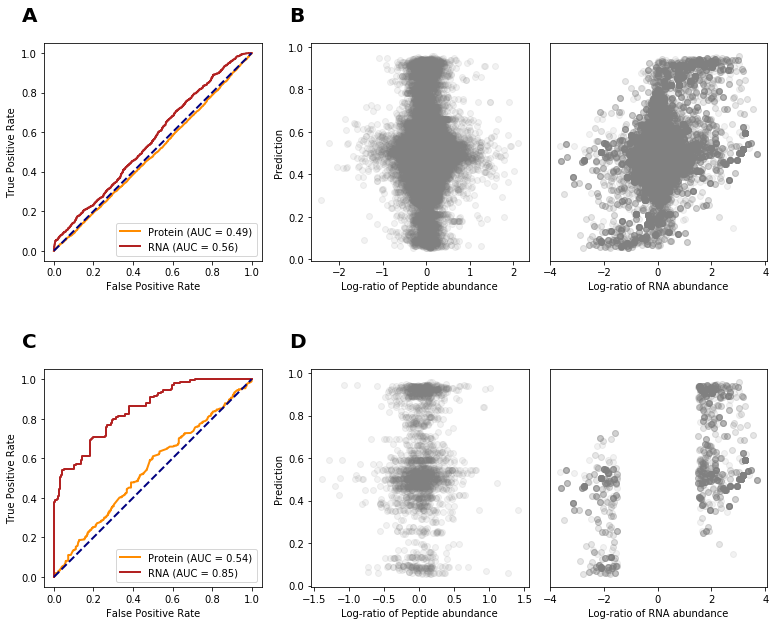

In [43]:
fig = plt.figure(figsize=(15, 10))

gs = gridspec.GridSpec(2,3, wspace=-.2, hspace=.5)
gs1 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gs[1:3], wspace=-.3)
gs2 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gs[4:6], wspace=-.3)

ax11 = fig.add_subplot(gs[0, 0])
ax12 = fig.add_subplot(gs1[0])
ax13 = fig.add_subplot(gs1[1])
ax21 = fig.add_subplot(gs[1, 0])
ax22 = fig.add_subplot(gs2[0])
ax23 = fig.add_subplot(gs2[1])

lw = 2
# ROC for all data
ax11.plot(fpr_all[0], tpr_all[0], color='darkorange',
         lw=lw, label='Protein (AUC = %0.2f)' % roc_auc_all[0])
ax11.plot(fpr_all[1], tpr_all[1], color='firebrick',
         lw=lw, label='RNA (AUC = %0.2f)' % roc_auc_all[1])
ax11.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax11.set(xlabel='False Positive Rate',
        ylabel='True Positive Rate',
        aspect="equal")
# ax11.legend(bbox_to_anchor=(.5, -0.25), loc="upper center")
ax11.legend(loc="lower right")

# ROC for differing RNA levels
ax21.plot(fpr_diff[0], tpr_diff[0], color='darkorange',
         lw=lw, label='Protein (AUC = %0.2f)' % roc_auc_diff[0])
ax21.plot(fpr_diff[1], tpr_diff[1], color='firebrick',
         lw=lw, label='RNA (AUC = %0.2f)' % roc_auc_diff[1])
ax21.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax21.set(xlabel='False Positive Rate',
        ylabel='True Positive Rate',
        aspect="equal")
# ax21.legend(bbox_to_anchor=(.5, -0.25), loc="upper center")
ax21.legend(loc="lower right")


# Plot prediction vs difference between genes
# All genes
color = "gray"
ax12.scatter(to_plot.LR_protein,
            to_plot.Prediction,
            color=color, alpha=0.1)
ax13.scatter(to_plot.LR_RNA,
            to_plot.Prediction, 
            color=color,alpha=0.1)
ax13.yaxis.set_visible(False)
ax12.set(xlabel='Log-ratio of Peptide abundance', ylabel='Prediction', aspect=1.0/ax12.get_data_ratio())
ax13.set(xlabel='Log-ratio of RNA abundance', aspect=1.0/ax13.get_data_ratio())

# Differentially expressed genes
color = "gray"
ax22.scatter(to_plot_diff.LR_protein,
            to_plot_diff.Prediction,
            color=color, alpha=0.1)
ax23.scatter(to_plot_diff.LR_RNA,
            to_plot_diff.Prediction, 
            color=color,alpha=0.1)
ax23.yaxis.set_visible(False)
ax22.set(xlabel='Log-ratio of Peptide abundance', ylabel='Prediction', aspect=1.0/ax22.get_data_ratio())
ax23.set(xlabel='Log-ratio of RNA abundance', aspect=1.0/ax23.get_data_ratio())

# Add subplot labels
ax11.text(-0.1, 1.1, "A", transform=ax11.transAxes, 
            size=20, weight='bold')
ax12.text(-0.1, 1.1, "B", transform=ax12.transAxes, 
            size=20, weight='bold')
ax21.text(-0.1, 1.1, "C", transform=ax21.transAxes, 
            size=20, weight='bold')
ax22.text(-0.1, 1.1, "D", transform=ax22.transAxes, 
            size=20, weight='bold')

plt.show()